# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

In [7]:
df.shape

(226, 49)

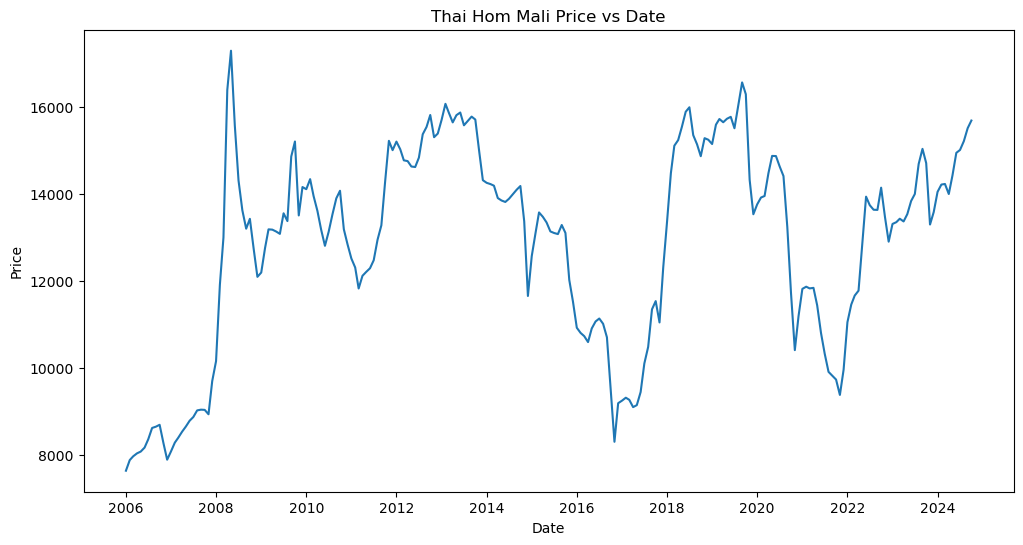

In [8]:
#plot the "nonglu_price" column vs date to see the trend
plt.figure(figsize=(12,6))
plt.plot(df['hommali_price'])
plt.title('Thai Hom Mali Price vs Date')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

# Stationarity Check

In [10]:
result = adfuller(df['hommali_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.856593427179576
p-value: 0.05063344055361135
Critical Values:
   1%: -3.460018927623594
   5%: -2.8745897386146817
   10%: -2.57372514086348


In [11]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Adds some features

In [13]:
import warnings
warnings.filterwarnings("ignore")

# Calculate ratio between current price and 6-month moving average to possibly detect unusual acceleration
# Likely the most viable and valuable of the options listed
df['price_vs_6ma'] = df['hommali_price'] / df['hommali_price'].rolling(6).mean()

# Add lagged fertilizer prices to possibly catch early price pressure signals
# Might be noisy due to long lead time - could be adjusted?
df['fert1_lag6m'] = df['fertilizer_1'].shift(6)

# Calculate month-over-month percent changes for grain prices to possibly capture rapid market shifts
# Could be quite noisy and act more as a lagging indicator than a leading indicator
df['nonglu_mom'] = df['nonglu_price'].pct_change()
df['hommali_mom'] = df['hommali_price'].pct_change() 
df['paddy_mom'] = df['paddy_price_index'].pct_change()

# Impute NaN 
df['price_vs_6ma'].fillna(df['price_vs_6ma'].iloc[7],inplace=True)
df['fert1_lag6m'].fillna(df['fert1_lag6m'].iloc[7],inplace=True)
df['nonglu_mom'].fillna(df['nonglu_mom'].iloc[1],inplace=True)
df['hommali_mom'].fillna(df['hommali_mom'].iloc[1],inplace=True)
df['paddy_mom'].fillna(df['paddy_mom'].iloc[1],inplace=True)

# Model

In [15]:
# Create the target
y = df['hommali_price']

# Define independent variables (predictors) X

# take hommali_price, paddy_price_index, cpi_rice out 
# and add 'price_vs_6ma','price_vs_6ma', 'fert1_lag6m','nonglu_mom', 'hommali_mom', 'paddy_mom'
xvars = ['agri_prod_index', 'crops_prod_index','paddy_prod_index', 
         'nonglu_prod_index', 'hommali_prod_index',
         'agri_price_index', 'crops_price_index', 'agri_export_value', 
         'ricet_export_amount', 'cpi',
         'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
         'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6',
         'water_station_B10', 
         'water_station_C13', 'water_station_C2', 'water_station_G8',
         'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
         'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
         'water_station_M6A', 'water_station_M7', 'water_station_N1',
         'water_station_N67', 'water_station_Ny1B', 
         'water_station_P1','water_station_P17',
         'water_station_S4B', 'water_station_Sw5A',
         'water_station_Y17', 'water_station_Y1C',
         'price_vs_6ma','price_vs_6ma', 'fert1_lag6m',
         'nonglu_mom', 'hommali_mom', 'paddy_mom']


# Adjust X to match the same periods
X = df[xvars]

In [16]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 48), (25, 48), (201,), (25,))

In [17]:
X_train['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01') else 0 for date in y_train.index]
X_test['shock_event'] = [1 if date >= pd.to_datetime('2023-12-01')  else 0 for date in y_test.index]

# If the sharp drop can be explained through existing exogenous variables or lagged 
# effects, a shock variable may not add significant predictive value.
# If the drop reflects a unique, external event, the shock variable might be the key 
# to improving forecasts.

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [20]:
label = 'hommali_price'
df = df[xvars + [label]]

train_data = df[df.index < '2023-01-01']
test_data = df[df.index >= '2023-01-01']

X_train = train_data.drop(columns=['hommali_price'])
y_train = train_data['hommali_price']

X_test = test_data.drop(columns=['hommali_price'])
y_test = test_data['hommali_price']

In [21]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204, 48), (22, 48), (204,), (22,))

In [23]:
# Prediction
y_pred = lr.predict(X_test)

In [24]:
# Evaluate the model
print(f"Linear Regression Testing MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Linear Regression Testing R-squared: {r2_score(y_test, y_pred):.4f}")

Linear Regression Testing MSE: 1842293.2746
Linear Regression Testing R-squared: -2.3590


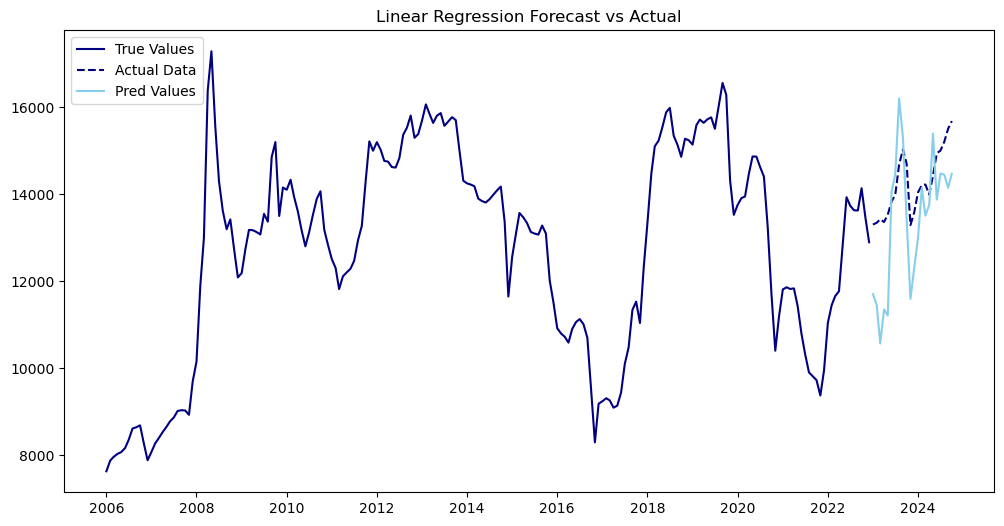

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [27]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,agri_prod_index,39.896827
1,crops_prod_index,-20.933445
2,paddy_prod_index,1.813108
3,nonglu_prod_index,-3.378448
4,hommali_prod_index,-2.128277
5,agri_price_index,-8.804283
6,crops_price_index,-0.688647
7,agri_export_value,0.660208
8,ricet_export_amount,-0.002258
9,cpi,60.181627


## 2. ARIMA Model

### Model 2 : ARIMA

In [30]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [31]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [32]:
# Evaluate the arima model
print(f"MSE : {mean_squared_error(y_test, arimax1_forecast):.4f}")
print(f"RMSE :{root_mean_squared_error(y_test, arimax1_forecast):.4f}")

MSE : 278381.2726
RMSE :527.6185


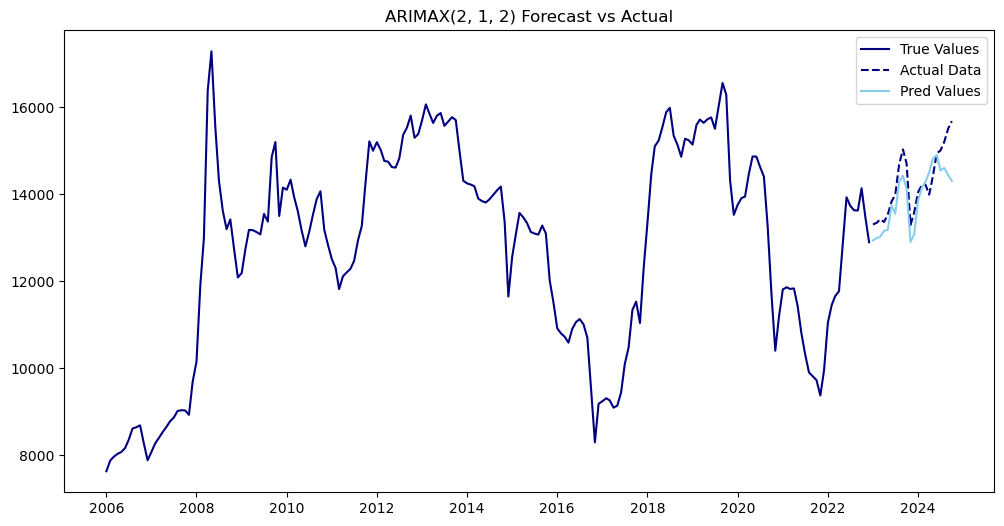

In [33]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

### Feature Importance

In [35]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          hommali_price   No. Observations:                  204
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1368.577
Date:                Wed, 18 Dec 2024   AIC                           2843.153
Time:                        10:36:02   BIC                           3018.753
Sample:                    01-01-2006   HQIC                          2914.194
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
agri_prod_index        10.0663      7.054      1.427      0.154      -3.759      23.892
crops_prod_index       -5.9161      5.156     -1.147      0.251     -16.021       4.189
paddy_prod_index        1.0550      1.779      0.593      0.553      -2.432       4.542
nonglu_prod_index      -1.2882      1.126     -1.144      0.252      -3.494       0.918
hommali_prod_index     -0.5515      0.598     -0.922      0.356      -1.723       0.620
agri_price_index      -65.7584     29.261     -2.247      0.025    -123.109      -8.408
crops_price_index      53.9137     21.336      2.527      0.012      12.096      95.731
agri_export_value       0.1938      0.140      1.383      0.167      -0.081       0.469
ricet_export_amount    -0.0003      0.000     -1.979      0.048      -0.001   -2.49e-06
cpi                   165.1681     46.855      3.525      0.000      73.335     257.002
pol_rate              143.2382    212.503      0.674      0.500    -273.260     559.736
neer                  -11.0159     47.586     -0.231      0.817    -104.283      82.251
reer                   12.5545     53.519      0.235      0.815     -92.341     117.450
sirikit_water           0.3141      0.271      1.159      0.246      -0.217       0.845
bhumibol_water          0.0532      0.089      0.596      0.551      -0.122       0.228
fertilizer_1           -0.0923      0.053     -1.740      0.082      -0.196       0.012
fertilizer_2           -0.0400      0.042     -0.941      0.347      -0.123       0.043
fertilizer_3            0.0514      0.047      1.090      0.276      -0.041       0.144
fertilizer_4            0.0081      0.032      0.252      0.801      -0.055       0.071
fertilizer_5           -0.0141      0.045     -0.316      0.752      -0.102       0.073
fertilizer_6            0.0521      0.032      1.640      0.101      -0.010       0.114
water_station_B10       0.1775      0.601      0.295      0.768      -1.000       1.355
water_station_C13       0.0546      0.066      0.827      0.408      -0.075       0.184
water_station_C2       -0.0730      0.104     -0.704      0.482      -0.276       0.130
water_station_G8       -0.0343      0.942     -0.036      0.971      -1.880       1.812
water_station_K10      -0.0156      0.144     -0.108      0.914      -0.298       0.267
water_station_K11A     -0.0246      0.115     -0.214      0.831      -0.250       0.201
water_station_Kgt3      0.2485      0.134      1.848      0.065      -0.015       0.512
water_station_Kh103    -0.5114      1.117     -0.458      0.647      -2.701       1.678
water_station_Kh58A    -0.0870      0.321     -0.271      0.786      -0.716       0.542
water_station_Kh72      1.8102      2.070      0.874      0.382      -2.247       5.868
water_station_M6A      -0.0282      0.081     -0.347      0.729      -0.187       0.131
water_station_M7        0.0288      0.030      0.975      0.329      -0.029       0.087
water_station_N1       -0.2892      0.347     -0.834      0.404      -0.9

### Model 3 : Auto ARIMA

In [37]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1571.615
Date:                Wed, 18 Dec 2024   AIC                           3147.229
Time:                        10:36:02   BIC                           3153.856
Sample:                    01-01-2006   HQIC                          3149.910
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3961      0.056      7.097      0.000       0.287       0.505
sigma2      3.079e+05   1.49e+04     20.707      0.000    2.79e+05    3.37e+05
Ljung-Box (L1) (Q):                   0.24   Jarque-

In [38]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (0, 1, 1), # ARIMA parameters: (p=0, d=1, q=1)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [39]:
# Evaluate the model_3
print(f"MSE : {mean_squared_error(y_test, arimax2_forecast):.4f}")
print(f"RMSE :{root_mean_squared_error(y_test, arimax2_forecast):.4f}")

MSE : 1057170.1623
RMSE :1028.1878


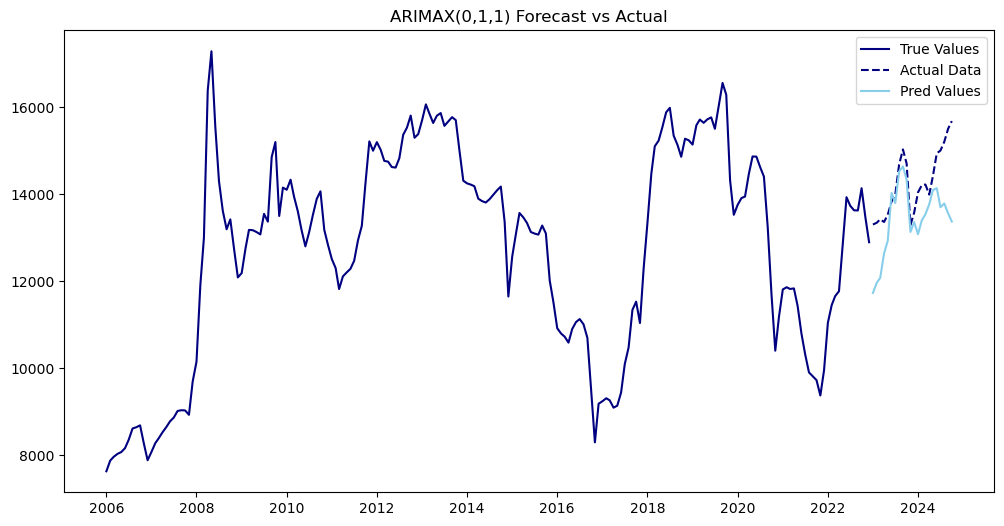

<Figure size 640x480 with 0 Axes>

In [40]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(0,1,1) Forecast vs Actual")
plt.legend()
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX(0,1,1) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [42]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          hommali_price   No. Observations:                  204
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1400.588
Date:                Wed, 18 Dec 2024   AIC                           2901.176
Time:                        10:36:09   BIC                           3066.837
Sample:                    01-01-2006   HQIC                          2968.196
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
agri_prod_index        10.0649      9.272      1.085      0.278      -8.108      28.238
crops_prod_index       -5.9180      6.873     -0.861      0.389     -19.389       7.553
paddy_prod_index        1.0509      1.942      0.541      0.588      -2.755       4.856
nonglu_prod_index      -1.2885      1.293     -0.997      0.319      -3.822       1.245
hommali_prod_index     -0.5614      0.677     -0.830      0.407      -1.888       0.765
agri_price_index      -65.7584     37.684     -1.745      0.081    -139.618       8.101
crops_price_index      53.9138     27.442      1.965      0.049       0.129     107.698
agri_export_value       0.1950      0.173      1.125      0.261      -0.145       0.535
ricet_export_amount    -0.0003      0.000     -2.105      0.035      -0.001    -2.3e-05
cpi                   165.1682     54.065      3.055      0.002      59.203     271.133
pol_rate              143.2382    224.354      0.638      0.523    -296.489     582.965
neer                  -11.0158     61.116     -0.180      0.857    -130.802     108.770
reer                   12.5546     68.325      0.184      0.854    -121.359     146.468
sirikit_water           0.3291      0.346      0.951      0.342      -0.349       1.007
bhumibol_water          0.0548      0.115      0.478      0.633      -0.170       0.280
fertilizer_1           -0.0914      0.065     -1.407      0.159      -0.219       0.036
fertilizer_2           -0.0109      0.047     -0.229      0.819      -0.104       0.082
fertilizer_3            0.1066      0.054      1.974      0.048       0.001       0.212
fertilizer_4            0.0138      0.030      0.456      0.648      -0.045       0.073
fertilizer_5            0.0272      0.052      0.520      0.603      -0.075       0.129
fertilizer_6            0.0810      0.043      1.893      0.058      -0.003       0.165
water_station_B10       0.1794      0.836      0.215      0.830      -1.460       1.819
water_station_C13       0.0552      0.080      0.691      0.489      -0.101       0.212
water_station_C2       -0.0737      0.134     -0.548      0.583      -0.337       0.190
water_station_G8       -0.0341      1.142     -0.030      0.976      -2.272       2.204
water_station_K10      -0.0122      0.186     -0.065      0.948      -0.377       0.352
water_station_K11A     -0.0168      0.159     -0.105      0.916      -0.329       0.295
water_station_Kgt3      0.2594      0.164      1.581      0.114      -0.062       0.581
water_station_Kh103    -0.5117      1.505     -0.340      0.734      -3.461       2.438
water_station_Kh58A    -0.0866      0.439     -0.197      0.844      -0.947       0.774
water_station_Kh72      1.8102      2.483      0.729      0.466      -3.057       6.677
water_station_M6A      -0.0197      0.068     -0.288      0.773      -0.154       0.114
water_station_M7        0.0290      0.027      1.073      0.283      -0.024       0.082
water_station_N1       -0.2775      0.484     -0.574      0.566      -1.2

## 3. ARIMAX + GARCH Model

### Model 4 : ARIMAX + GARCH

In [45]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

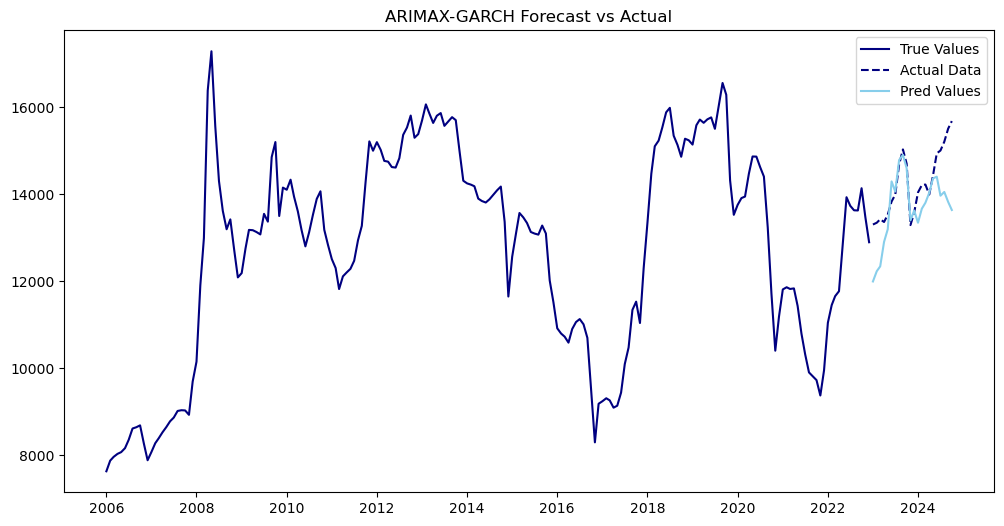

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")
plt.show()
# saving the plot as an image
plt.savefig('../figure/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

In [47]:
# Assuming the variable name is "model," we can extract three key GARCH coefficients:
# omega: constant term
# alpha: ARCH term (impact of past squared returns)
# beta: GARCH term (persistence of volatility)

# Try something like this...
print('GARCH Coefficients:')
print('omega (constant):', arimax2_model.params['omega'])
print('alpha (ARCH term):', arimax2_model.params['alpha[1]'])
print('beta (GARCH term):', arimax2_model.params['beta[1]'])

GARCH Coefficients:


KeyError: 'omega'

In [ ]:
# Assuming the variable name is "model"

print('AR(1):', arimax2_model.params[1])  # AR coefficient
print('MA(1):', arimax2_model.params[2])  # MA coefficient


# Or possibly from your ARIMA(X):
print('AR(1):', arimax2_model.params['ar.L1'])     # AR coefficient
print('MA(1):', arimax2_model.params['ma.L1'])     # MA coefficient

for name in exog_df.columns:
    print(f'{name}:', arimax2_model.params[name])   # exog coefficients